# Pixel clustering notebook

In [ ]:
# import required packages
from datetime import datetime as dt
import os
import subprocess

import feather
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr

from ark.analysis import visualize
from ark.phenotyping import som_utils
from ark.utils import data_utils, io_utils, load_utils, plot_utils

## 0: set file paths and parameters

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (generated from `Segment_Image_Data.ipynb`). This directory will also store all of the directories/files created during pixel clustering.
* `tiff_dir`: the path to the directory containing your imaging data
* `img_sub_folder`: if `tiff_dir` contains an additional subfolder structure, override `None` with the appropriate value
* `segmentation_dir`: the path to the directory containing your segmentations (generated from `Segment_Image_Data.ipynb`). Set this argument to `None` if you do not have segmentation labels or wish to run pixel clustering without them. However, note that you will not be able to run cell clustering as that process is heavily dependent on them.
* `seg_suffix`: the suffix plus the file extension of the segmented images for each fov. Note that these should be the same for all FOVs and that normally, the value should be `'_feature_0.tif'`. This argument will be ignored if `segmentation_dir` is set to `None`
* `MIBItiff`: if the images in `tiff_dir` are mibitiff or not
* `mibitiff_suffix` (required if `MIBItiff` is True): the file suffix all mibitiff images contain

In [ ]:
base_dir = "../data/granulomaCohort_allData"
tiff_dir = os.path.join(base_dir, "TIFs")
img_sub_folder = None
segmentation_dir = "../data/granulomaCohort_allData"
seg_suffix = '_feature_0.tif'
MIBItiff = False
mibitiff_suffix = '-MassCorrected-Filtered.tiff'

* `fovs` (optional): set a specific set of fovs to load, default loads all the fovs in `tiff_dir`

In [ ]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ['fov14']

## 1: Preprocess

Set a prefix to be applied to all data directories/files created by pixel and cell clustering. If the prefix is not set, a default of the datetime at the start of the run is used. The following data directories/files will be created for preprocessing:

* `preprocessed_dir`: the name of the directory to save the preprocessed pixel data
* `subsetted_dir`: the name of the directory to save the subsetted pixel data

In [ ]:
# explicitly set pixel_cluster_prefix to override datetime default
pixel_cluster_prefix = None

if pixel_cluster_prefix is None:
    pixel_cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')
    
preprocessed_dir = '%s_pixel_mat_preprocessed' % pixel_cluster_prefix
subsetted_dir = '%s_pixel_mat_subsetted' % pixel_cluster_prefix

Set the following arguments

* `channels`: set a subset to run pixel clustering over
* `blur_factor`: the sigma to use for the Gaussian filter when running the Gaussian blur. Higher values are more aggressive in smoothing signal.
* `subset_proportion`: the fraction of pixels to take from each fov. Sampling is random.

In [ ]:
channels = ["CD45", "SMA", "Vimentin", "CD31", "Keratin-pan", "E-cadherin", "MastChyTry",
            "MPO", "CD20", "CD3", "CD14", "HLA-DR-DQ-DP", "Foxp3", "CD16", "CD11c", "CD206",
            "CD11b", "CD68", "CD163", "CD209"]
blur_factor = 2
subset_proportion = 0.1

During pixel preprocessing, the following is done for each FOV:

* Gaussian blur each channel separately
* Remove empty pixels
* Normalize the row sums of the remaining pixels, this creates the preprocessed dataset
* Subset `subset_proportion` pixels, this creates the subsetted dataset

Note: if you get integer overflow errors loading in your data, try changing the `dtype` argument to a larger type.

In [ ]:
# run pixel data preprocessing
som_utils.create_pixel_matrix(
    fovs,
    channels,
    base_dir,
    tiff_dir,
    segmentation_dir,
    img_sub_folder=img_sub_folder,
    seg_suffix=seg_suffix,
    pre_dir=preprocessed_dir,
    subset_dir=subsetted_dir,
    is_mibitiff=MIBItiff,
    blur_factor=blur_factor,
    subset_proportion=subset_proportion,
    dtype="int16"
)

## 2: pixel clustering

### 2.1: train pixel SOM

The following data directories/files will be created for pixel clustering:

* `pixel_clustered_dir`: directory to store pixel data with just the pixel SOM cluster assignments
* `pixel_consensus_dir`: directory to store pixel data with the pixel SOM and consensus cluster assignments
* `pixel_weights_name`: file name to place the pixel SOM weights
* `norm_vals_name`: file name to store the values to normalize the full dataset when assigning pixel SOM cluster labels. These are calculated on the subsetted dataset during pixel SOM training
* `pixel_som_to_meta_name`: file name to store the mapping between pixel SOM clusters and pixel meta clusters
* `pc_chan_avg_som_cluster_name`: file name to store the average channel expression across all pixel SOM clusters
* `pc_chan_avg_meta_cluster_name`: same as above except for pixel meta clusters

In [ ]:
# define the paths using specified prefix
pixel_clustered_dir = '%s_pixel_mat_clustered' % pixel_cluster_prefix
pixel_consensus_dir = '%s_pixel_mat_consensus' % pixel_cluster_prefix
pixel_weights_name = '%s_pixel_weights.feather' % pixel_cluster_prefix
norm_vals_name = '%s_norm_vals.feather' % pixel_cluster_prefix
pixel_som_to_meta_name = '%s_pixel_som_to_meta.feather' % pixel_cluster_prefix
pc_chan_avg_som_cluster_name = '%s_pixel_channel_avg_som_cluster.csv' % pixel_cluster_prefix
pc_chan_avg_meta_cluster_name = '%s_pixel_channel_avg_meta_cluster.csv' % pixel_cluster_prefix

Train the pixel SOM on the subsetted data. Training is done using the `FlowSOM` algorithm.

Note that each channel is normalized by their 99.9% value across the entire subsetted dataset before training. These values get saved to `norm_vals_name`.

For a full set of parameters you can customize for train_pixel_som, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.train_pixel_som>pixel training docs</a>

NOTE: if you get `NA`/`NaN`/`Inf` errors, you will likely need to increase the subset proportion in the call to `create_pixel_matrix` and/or increase the number of FOVs included (if you subsetted).

In [ ]:
# create the pixel-level SOM weights
som_utils.train_pixel_som(
    fovs,
    channels,
    base_dir,
    subset_dir=subsetted_dir,
    norm_vals_name=norm_vals_name,
    weights_name=pixel_weights_name,
    num_passes=10
)

### 2.2: Assign pixel SOM clusters

Use the SOM weights learned from `train_pixel_som` to assign pixel clusters to the full preprocessed dataset.

Note that each channel is normalized by the respective value stored in `norm_vals_name` (computed in `train_pixel_som`) prior to cluster assignment.

This function also computes the average channel expression (z-scored) across all pixel SOM clusters (the data placed in `pc_chan_avg_som_cluster_name`) as well as the number of pixels in each pixel SOM cluster. This is needed for consensus clustering.

In [ ]:
# use pixel SOM weights to assign pixel clusters
som_utils.cluster_pixels(
    fovs,
    channels,
    base_dir,
    pre_dir=preprocessed_dir,
    norm_vals_name=norm_vals_name,
    weights_name=pixel_weights_name,
    cluster_dir=pixel_clustered_dir,
    pc_chan_avg_som_cluster_name=pc_chan_avg_som_cluster_name
)

### 2.3: run pixel consensus clustering

With the SOM cluster labels assigned to the full preprocessed dataset, assign consensus cluster labels. The consensus clusters are trained on the average channel expression across all pixel SOM clusters (the data stored in `pc_chan_avg_som_cluster_name`): z-scored values are capped at the value specified in the `cap` argument prior to training.

After consensus clustering, the following are also computed:

* The average channel expression across all pixel meta clusters (z-scored), and the number of pixels per meta cluster (the data placed in `pc_chan_avg_meta_cluster_name`)
* The meta cluster mapping for each pixel SOM cluster in `pc_chan_avg_som_cluster_name` (data is resaved, same data except with an associated meta cluster column)

For a full set of parameters you can customize for pixel_consensus_cluster, please consult: <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.som_utils.pixel_consensus_cluster>pixel consensus clustering docs</a>

* `max_k`: the number of consensus clusters desired
* `cap`: used to clip z-scored values prior to consensus clustering (in the range `[-cap, cap]`)

In [ ]:
max_k = 20
cap = 3

# run hierarchical clustering based on pixel SOM cluster assignments
som_utils.pixel_consensus_cluster(
    fovs,
    channels,
    base_dir,
    max_k=max_k,
    cap=cap,
    cluster_dir=pixel_clustered_dir,
    pc_chan_avg_som_cluster_name=pc_chan_avg_som_cluster_name,
    pc_chan_avg_meta_cluster_name=pc_chan_avg_meta_cluster_name,
    clust_to_meta_name=pixel_som_to_meta_name,
    consensus_dir=pixel_consensus_dir
)

**After remapping, re-run this cell and everything below (except 3.5)**

In [ ]:
pixel_channel_avg_som_cluster = pd.read_csv(os.path.join(base_dir, pc_chan_avg_som_cluster_name))
pixel_channel_avg_meta_cluster = pd.read_csv(os.path.join(base_dir, pc_chan_avg_meta_cluster_name))

## 3: visualize results

### 3.1: number of pixels per SOM cluster

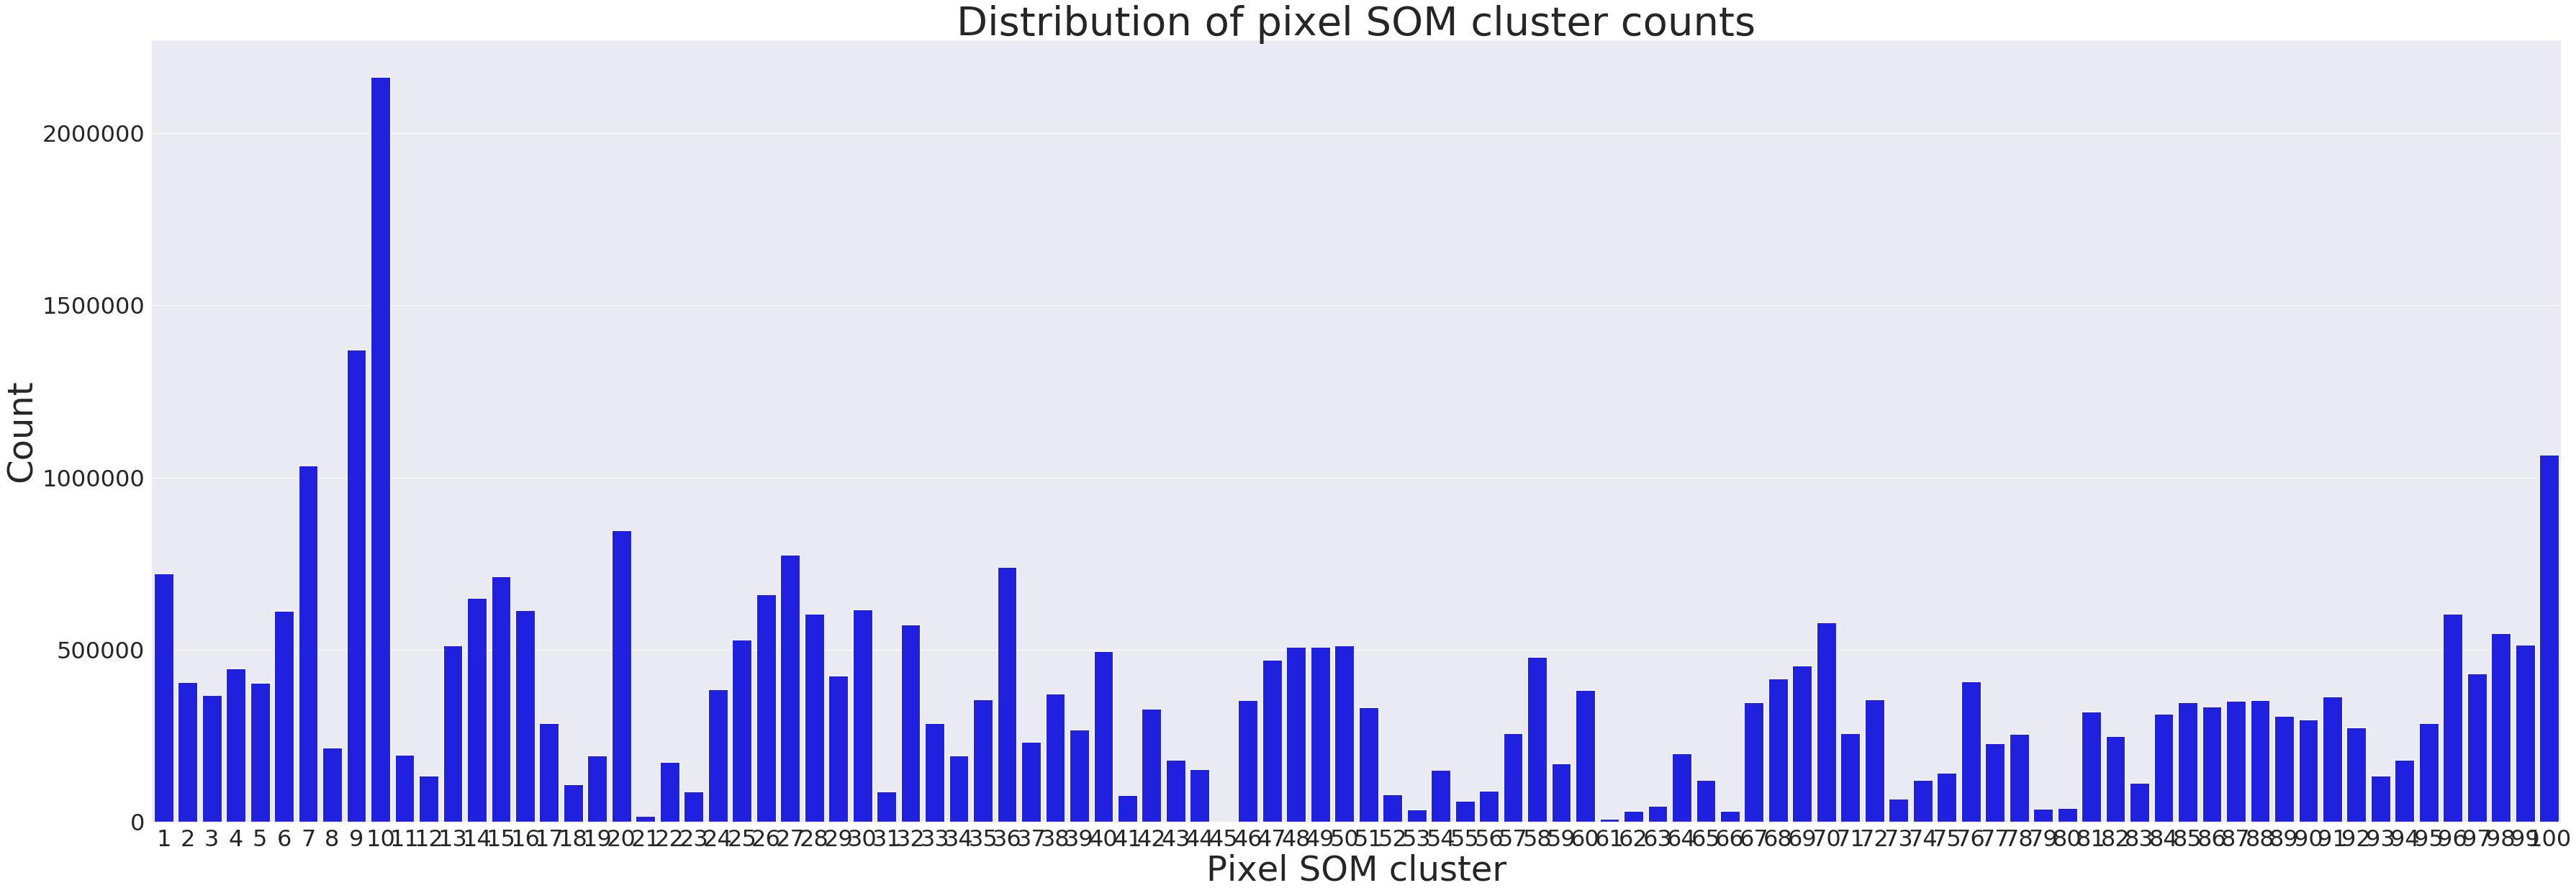

In [26]:
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(
    x=pixel_channel_avg_som_cluster['pixel_som_cluster'],
    y=pixel_channel_avg_som_cluster['count'],
    palette=['#0000FF' for i in range(pixel_channel_avg_som_cluster.shape[0])]
)
_ = plt.title('Distribution of pixel SOM cluster counts', fontsize=56)
_ = plt.xlabel('Pixel SOM cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### 3.2: pixel SOM cluster average over channels (z-scored)

In [ ]:
# define the colormap
meta_cluster_labels = pixel_channel_avg_som_cluster['pixel_meta_cluster'].unique()
color_palette = sns.color_palette("hls", len(meta_cluster_labels))
colormap = dict(zip(meta_cluster_labels, color_palette))

# map the values, then reindex based on pixel_som_cluster values
som_cluster_index = pixel_channel_avg_som_cluster['pixel_som_cluster'].values
meta_cluster_mapping = pd.Series(pixel_channel_avg_som_cluster['pixel_meta_cluster']).map(colormap)
meta_cluster_mapping.index = som_cluster_index

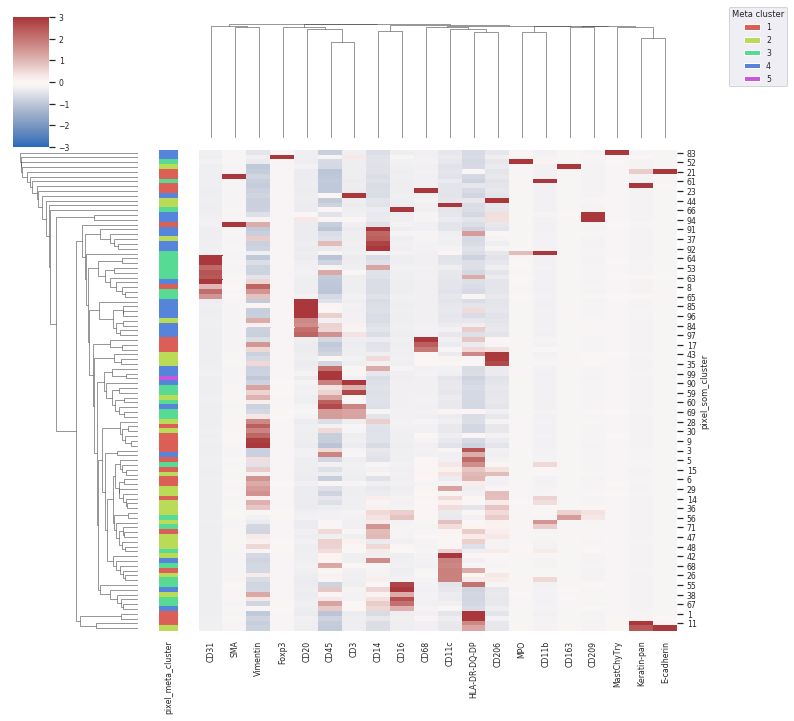

In [28]:
# draw the heatmap
visualize.draw_heatmap(
    stats.zscore(pixel_channel_avg_som_cluster.loc[:, channels].values),
    pixel_channel_avg_som_cluster['pixel_som_cluster'],
    channels,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=meta_cluster_mapping,
    colormap='vlag'
)

# add a legend for pixel_meta_cluster
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='Meta cluster',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

### 3.3: number of pixels per meta cluster

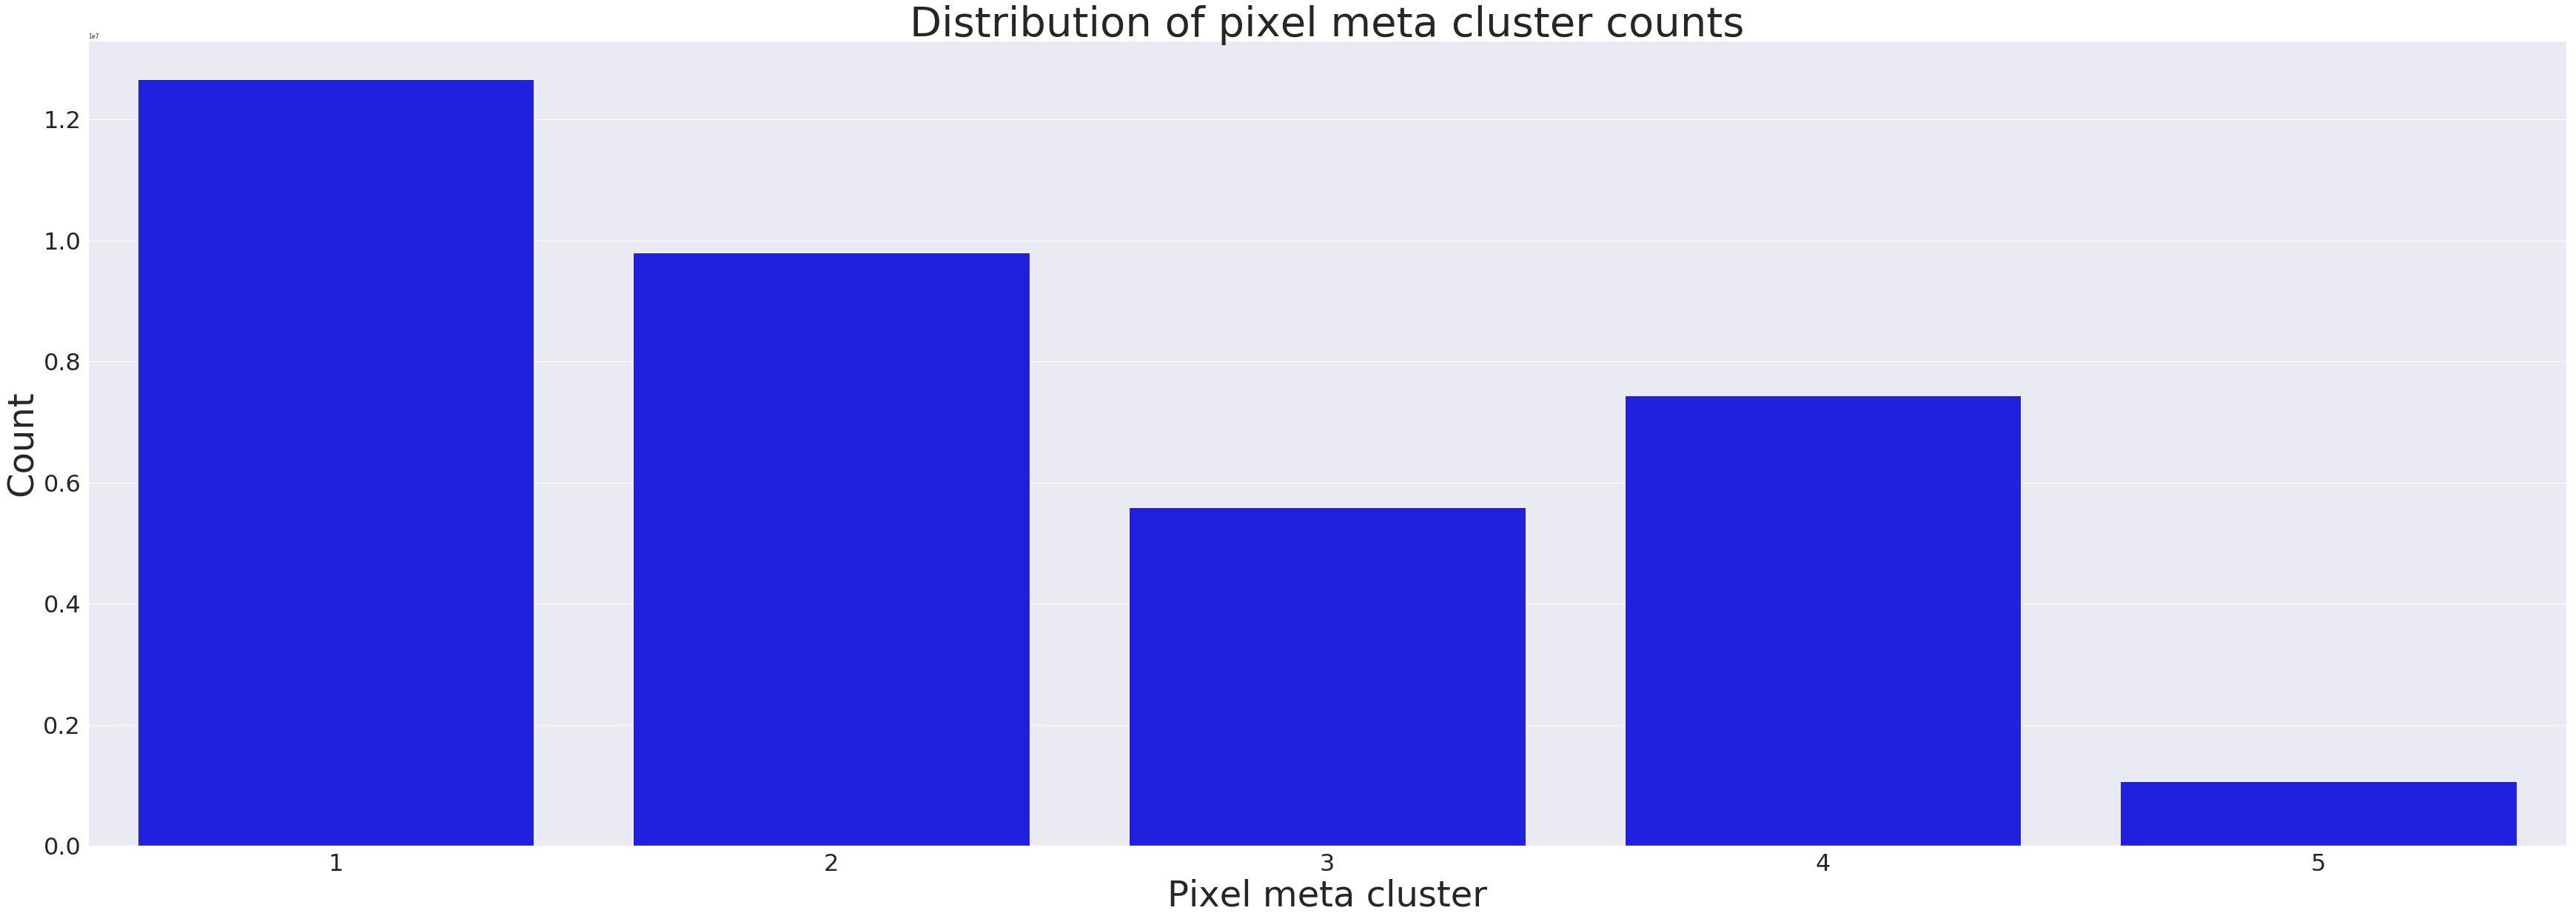

In [29]:
_ = plt.figure(figsize=(60, 20))
_ = sns.barplot(
    x=pixel_channel_avg_meta_cluster['pixel_meta_cluster'],
    y=pixel_channel_avg_meta_cluster['count'],
    palette=['#0000FF' for i in range(pixel_channel_avg_meta_cluster.shape[0])]
)
_ = plt.title('Distribution of pixel meta cluster counts', fontsize=56)
_ = plt.xlabel('Pixel meta cluster', fontsize=48)
_ = plt.ylabel('Count', fontsize=48)
_ = plt.xticks(fontsize=32)
_ = plt.yticks(fontsize=32)

### 3.4: pixel meta cluster average over channels (z-scored)

In [ ]:
# define the colormap
meta_cluster_labels = pixel_channel_avg_meta_cluster['pixel_meta_cluster'].unique()
color_palette = sns.color_palette("hls", len(pixel_channel_avg_meta_cluster))
colormap = dict(zip(meta_cluster_labels, color_palette))

# map the values, then reindex based on pixel_meta_cluster values
meta_cluster_index = pixel_channel_avg_meta_cluster['pixel_meta_cluster'].values
meta_cluster_mapping = pd.Series(pixel_channel_avg_meta_cluster['pixel_meta_cluster']).map(colormap)
meta_cluster_mapping.index = meta_cluster_index

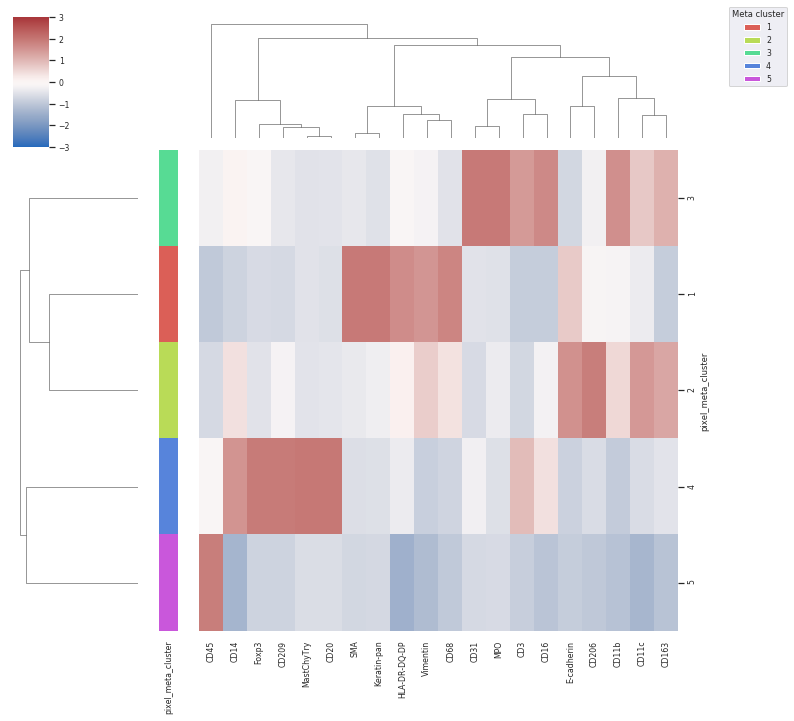

In [31]:
# visualize average channel expression for each pixel meta cluster
visualize.draw_heatmap(
    stats.zscore(pixel_channel_avg_meta_cluster.loc[:, channels].values),
    pixel_channel_avg_meta_cluster['pixel_meta_cluster'],
    channels,
    center_val=0,
    min_val=-3,
    max_val=3,
    cbar_ticks=np.arange(-3, 4),
    row_colors=meta_cluster_mapping,
    colormap='vlag'
)

# add a legend for pixel meta cluster
handles = [patches.Patch(facecolor=colormap[cmap_name]) for cmap_name in colormap]
_ = plt.legend(
    handles,
    colormap,
    title='Meta cluster',
    bbox_to_anchor=(1.1, 1),
    bbox_transform=plt.gcf().transFigure,
    loc='upper right'
)

Define a temporary sample meta cluster remapping

NOTE: this is a filler for the process done by Zak's interactive visualization

TODO: Zak's visualization spits out duplicate meta label columns when I tested it, need to take a look at this once merging that in

In [ ]:
sample_remapped_meta_clusters = {
    'som_cluster': [i for i in np.arange(1, 101)],
    'meta_cluster': [int(i / 25) + 1 for i in np.arange(1, 101)],
    'meta_cluster_dup': [int(i / 25) + 1 for i in np.arange(1, 101)]
}

sample_remapped_meta_clusters_df = pd.DataFrame.from_dict(sample_remapped_meta_clusters)
sample_remapped_meta_clusters_df.to_csv(os.path.join(base_dir, 'sample_remapped_pixel_meta_clusters.csv'), index=False)

### 3.5: use the interactive reclustering results to relabel pixel meta clusters and recompute average channel expression per pixel meta cluster

In [ ]:
som_utils.apply_pixel_meta_cluster_remapping(
    fovs,
    channels,
    base_dir,
    pixel_consensus_dir,
    'sample_remapped_pixel_meta_clusters.csv',
    pc_chan_avg_som_cluster_name,
    pc_chan_avg_meta_cluster_name
)

### 3.6: pixel cluster overlay

In [ ]:
# select fovs to display
pixel_fovs = ['fov6', 'fov7']

Note: set `pixel_cluster_col` param to `'pixel_som_cluster'` if you want to overlay SOM clusters instead

In [ ]:
# define the path to the channel file
if img_sub_folder is None:
    chan_file = os.path.join(fovs[0], os.listdir(os.path.join(tiff_dir, fovs[0]))[0])
else:
    chan_file = os.path.join(fovs[0], img_sub_folder, os.listdir(os.path.join(tiff_dir, fovs[0]))[0])

# generate the pixel cluster masks for each fov in pixel_fovs
pixel_cluster_masks = data_utils.generate_pixel_cluster_mask(
    fovs,
    base_dir,
    tiff_dir,
    chan_file=chan_file,
    pixel_consensus_dir=pixel_consensus_dir,
    pixel_cluster_col='pixel_meta_cluster'
)

* `save_pixel_masks`: replace with True if you want to save, files will be written as `{fov_name}_pixel_mask.tiff` in `base_dir`

In [ ]:
save_pixel_masks = False

if save_pixel_masks:
    data_utils.save_fov_images(
        pixel_fovs,
        base_dir,
        pixel_cluster_masks,
        name_suffix='_pixel_mask'
    )

Note: change `'pixel_meta_cluster'` to `'pixel_som_cluster'` if you want to overlay SOM clusters instead

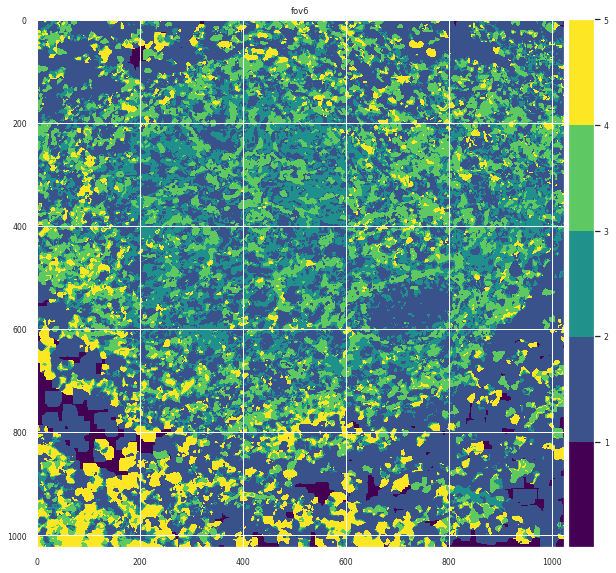

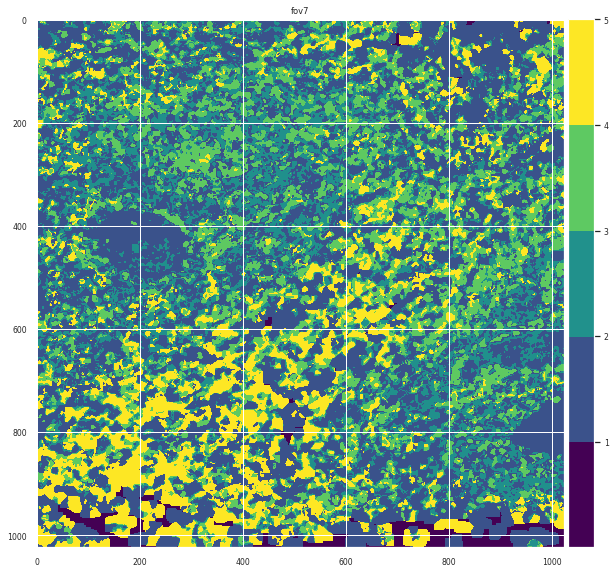

In [34]:
plot_utils.plot_clustering_result(
    pixel_cluster_masks,
    pixel_fovs,
    tick_range=np.arange(len(pixel_channel_avg_som_cluster['pixel_meta_cluster'].unique())) + 1
)

### 4: Save parameters for use in cell clustering

The following parameters are saved:

* `fovs`: the set of fovs
* `channels`: the subset of markers
* `segmentation_dir`: the path to the directory containing your segmentations (generated from `Segment_Image_Data.ipynb`)
* `pixel_consensus_dir`: the name of the directory containing pixel data with the pixel SOM and consensus cluster assignments
* `pc_chan_avg_som_cluster_name`: the name of the file containing the average marker channel expression per pixel SOM cluster, used for the visualization of weighted channel average per cell
* `pc_chan_avg_meta_cluster_name`: the name of the file containing the average marker channel expression per pixel meta cluster, used for the visualization of weighted channel average per cell

The save file will be `{pixel_cluster_prefix}_cell_clustering_params.json` and will be placed in `base_dir`. Note that the `base_dir` you use in `example_pixel_clustering.ipynb` should be the same as in `example_cell_clustering.ipynb`.

In [ ]:
# define the params dict
cell_clustering_params = {
    'fovs': fovs,
    'channels': channels,
    'segmentation_dir': segmentation_dir,
    'pixel_consensus_dir': pixel_consensus_dir,
    'pc_chan_avg_som_cluster_name': pc_chan_avg_som_cluster_name,
    'pc_chan_avg_meta_cluster_name': pc_chan_avg_meta_cluster_name
}

# save the params dict
with open(os.path.join(base_dir, '%s_cell_clustering_params.json' % pixel_cluster_prefix), 'w') as fh:
    json.dump(cell_clustering_params, fh)